<a href="https://colab.research.google.com/github/m-dabo/derivatives/blob/main/Deriv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codebook for open classroom
#### based on Derivatives Analytics by Y. H.

# General Requirements

In [1]:
# Packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Customization
mpl.rcParams['font.family'] = 'serif'

# Part I : The Market

## Ch. 2 : Market based valuation

Text(0, 0.5, 'Option value')

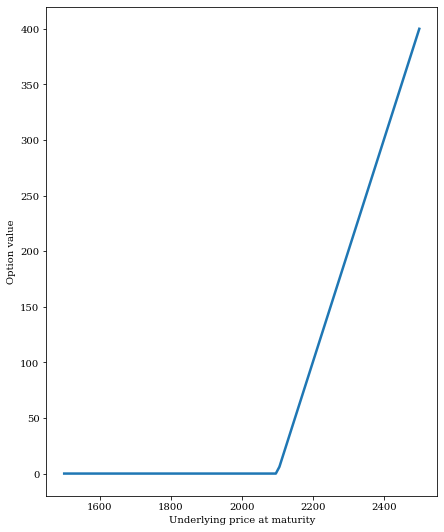

In [2]:
# Defining prices
K = 2100 # strike price
S = np.linspace(1500, 2500, 100) # underlying price vector
h = np.maximum(S - K, 0) # call option inner values

# Visualization
plt.figure(figsize = (7, 9))
plt.plot(S, h, lw = 2.5) # plot inner values at maturity
plt.xlabel('Underlying price at maturity')
plt.ylabel('Option value')